# Data Exploration

In [414]:
%mkdir -p /tmp
%curl https://raw.githubusercontent.com/urmzd/rabbit-classifier/main/resources/data.csv --output /tmp/data.csv

UsageError: Line magic function `%curl` not found.


In [415]:
import pandas as pd
import requests
import re
import pathlib
from loguru import logger

DATA_PATH="/tmp/data.csv"
IMAGE_PATH="/tmp/images"

def get_data():
  df = pd.read_csv(DATA_PATH, usecols=range(2))
  return df

def download_image(link: str) -> pathlib.Path:
  # view  : https://regex101.com/r/3bhDMM/1
  # delete: https://regex101.com/delete/N5sItwbrPF73ZllTnRDltxZ1
  file_name_regex = re.compile(r".*\/(.*(\.(jpeg|jpg|png))?)\??.*", flags=re.IGNORECASE)
  regex_matches = file_name_regex.match(link)

  if not regex_matches:
    raise Exception(f"Failed to match file_name for link {link}")

  if len(regex_matches.groups()) < 3:
    file_name = regex_matches.group(1) + ".png"
  else:
    file_name = regex_matches.group(1)

  content_path = pathlib.Path(IMAGE_PATH)
  content_path.mkdir(parents=True, exist_ok=True)

  file_path = content_path / file_name

  if file_path.exists():
    return file_path

  image_request_headers={
      'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'
  }

  image = requests.get(link, headers=image_request_headers)

  with open(file_path, "wb") as handle:
    handle.write(image.content)

  return file_path

df = get_data()
df.head()

,label,link
0,rabbit,https://upload.wikimedia.org/wikipedia/commons...
1,rabbit,https://upload.wikimedia.org/wikipedia/commons...
2,rabbit,https://www.massaudubon.org/var/ezdemo_site/st...
3,rabbit,https://www.welcomewildlife.com/wp-content/upl...
4,rabbit,https://i.natgeofe.com/k/58df97a7-5c47-44b8-97...


In [416]:
import cv2
from typing import NewType, Tuple, List
import numpy as np

Image = NewType('Image', np.array)
Label = NewType('Label', str)
ImageLabelPair = Tuple[Image, Label]

def get_image(file_path: pathlib.Path, show=False) -> Image:
  image = cv2.imread(str(file_path))

  if show:
    plt.imshow(image)
    
  return Image(image)

RawX = NewType('RawX', List[Image])
RawY = NewType('RawY', np.ndarray)

def get_x_y(raw_data: pd.DataFrame) -> Tuple[RawX, RawY]:
  y = raw_data.iloc[:, 0].to_numpy()
  y = y.reshape(-1, 1)

  x_links = raw_data.iloc[:, 1].tolist()
  x_paths = [download_image(link) for link in x_links]
  x = [get_image(path) for path in x_paths]

  return RawX(x), RawY(y)

In [417]:
from sklearn.preprocessing import OneHotEncoder
import albumentations as A
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from pipetools import pipe, foreach

random.seed(42)

DESIRED_HEIGHT = 200
DESIRED_WIDTH = 200
SCALE_HEIGHT = False

def get_scaled_dimensions(dim1: int, dim2:int, target_dim: int, reverse=False):
    aspect_ratio = dim1 / dim2
    scale_dim_by = dim2 / target_dim
    scaled_dim2 = round(dim2 / scale_dim_by)
    scaled_dim1 = round(dim1 / scale_dim_by * aspect_ratio)

    scaled_dims = (scaled_dim1, scaled_dim2)

    if reverse:
      return scaled_dims[::-1]

    return scaled_dims
    


def get_x_encoder():

  def change_image_to_greyscale(img: Image) -> Image:
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  def normalize_image(img: Image) -> Image:
    return cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

  def resize_image(img: Image) -> Image:
    height, width, _ = img.shape
    scaled_dims = get_scaled_dimensions(width, height, target_dim=DESIRED_WIDTH) if SCALE_HEIGHT else get_scaled_dimensions(height, width, target_dim=DESIRED_HEIGHT, reverse=True)
    return cv2.resize(img, scaled_dims)

  def pad_image(img: Image) -> Image:
    height, width = img.shape
    bottom = 0
    top = 0
    left = 0
    right = 0
    if SCALE_HEIGHT:
      width_padding_needed = max(DESIRED_WIDTH - width,0)
      width_padding_per_side = width_padding_needed // 2
      
      left = width_padding_per_side
      right = width_padding_per_side

      if width_padding_needed % 2 == 1:
        right += 1
    else:
      height_padding_needed = max(DESIRED_HEIGHT - height,0)
      height_padding_per_side = height_padding_needed // 2

      top = height_padding_per_side
      bottom = height_padding_per_side

      if height_padding_needed % 2 == 1:
        top += 1

    padded_image = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT)
    # return img
    return padded_image

  def crop_image(img: Image):
    height, width = img.shape

    h_low = 0
    h_high = DESIRED_HEIGHT
    w_low = 0
    w_high = DESIRED_WIDTH

    if SCALE_HEIGHT:
      difference = DESIRED_WIDTH - width
      crops = difference // 2
      w_low = 0 - crops
      w_high = width + crops

      if difference % 2 == 1:
        w_high += 1
    else:
      difference = DESIRED_HEIGHT - height
      crops = difference // 2
      h_low = 0 - crops
      h_high = height + crops

      if difference % 2 == 1:
        h_high += 1

    # return img

    return img[h_low:h_high, w_low:w_high]



  return pipe | resize_image | change_image_to_greyscale | normalize_image | pad_image | crop_image

def get_x_y_preprocessors(x: RawX, y: RawY):  
  y_encoder = OneHotEncoder(sparse=False).fit(y)
  x_encoder = get_x_encoder()

  return x_encoder, y_encoder

def get_processed_x_y(x: RawX, y: RawY):

  x_encoder, y_encoder = get_x_y_preprocessors(x, y)

  x_encoded = x > foreach(x_encoder) | list | np.array 

  y_encoded: np.ndarray = y_encoder.transform(y)

  return x_encoded, y_encoded

In [418]:
data = get_data()
x, y = get_x_y(data)

2022-03-16 11:56:22.781 | INFO     | __main__:<cell line: 7>:7 - DIMENSIONS: (200, 200) 
2022-03-16 11:56:22.782 | INFO     | __main__:<cell line: 8>:8 - MIN:  0.007905138656497002
2022-03-16 11:56:22.784 | INFO     | __main__:<cell line: 9>:9 - MAX:  1.0


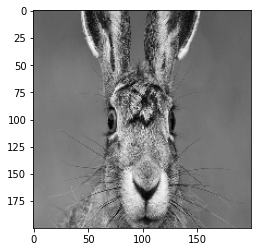

In [419]:
# raw_image = x[-1]
# image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2GRAY)
# image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
# logger.info(image.shape)
# logger.info(image.dtype)
image = get_processed_x_y(x, y)[0][-20]
logger.info(f"DIMENSIONS: {image.shape} ")
logger.info(f"MIN:  {np.min(image)}")
logger.info(f"MAX:  {np.max(image)}")
plt.imshow(image, cmap="gray")

# Data Processing